In [ ]:
!pip install torchmetrics

In [2]:
import torch as tc
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split

import torchvision as tv
from torchvision import models, datasets, transforms

from tqdm import tqdm

import matplotlib.pyplot as plt

from torchmetrics.detection import MeanAveragePrecision

from PIL import Image

from matplotlib.patches import Rectangle

import pandas as pd

import os

In [3]:
device  ='cuda' if tc.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
model = models.detection.fasterrcnn_resnet50_fpn(True)

In [5]:
model = model.to(device)

In [6]:
image = Image.open('/content/vignoble_-_reims_-_wwwmkbphotos-coll_adt_marne10.jpg').convert('RGB')

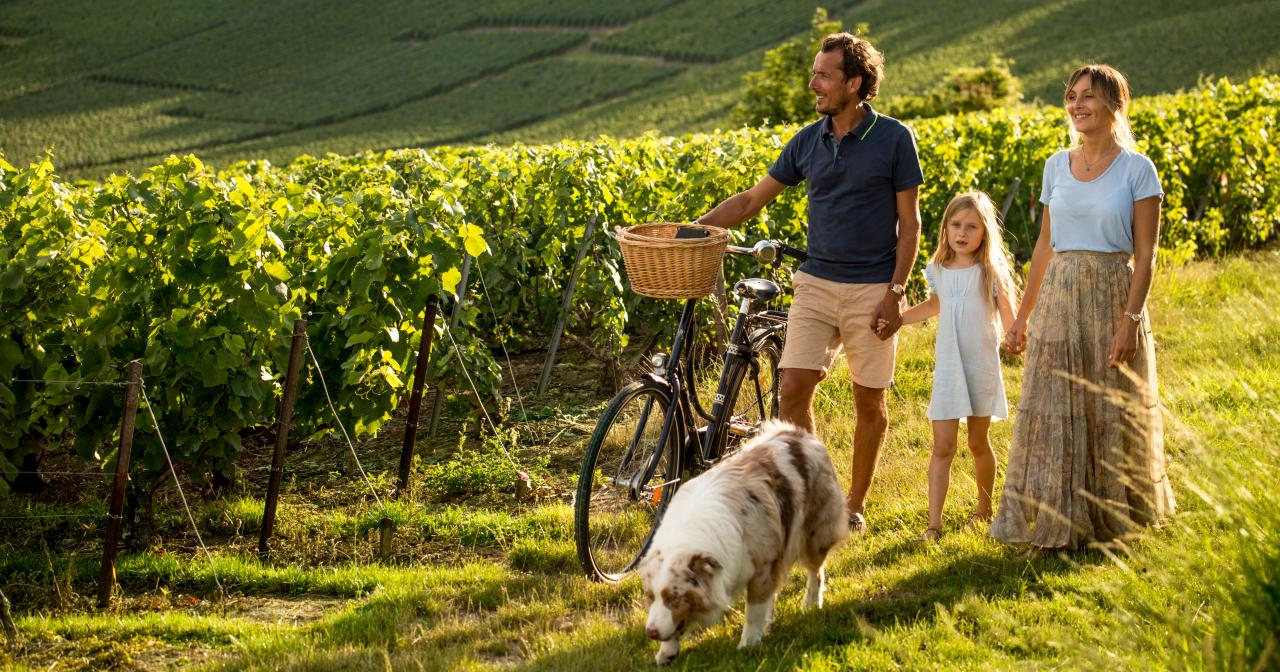

In [7]:
image

In [8]:
image_tensor = transforms.functional.to_tensor(image).to(device)

In [ ]:
model.eval()

In [10]:
with tc.no_grad():
  predict = model([image_tensor])

In [11]:
boxes = predict[0]['boxes'].cpu()
labels = predict[0]['labels'].cpu()
scores = predict[0]['scores'].cpu()

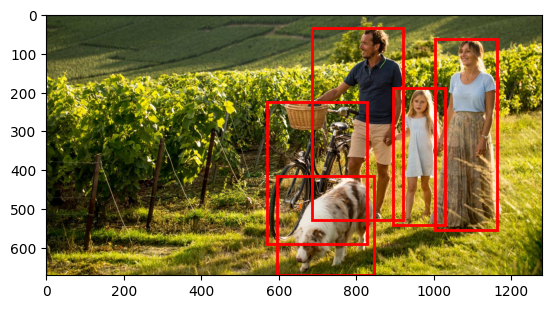

In [12]:
np_arr = image_tensor.permute(1, 2, 0).cpu()
plt.imshow(np_arr)

ax = plt.gca()
for box, label, score in zip(boxes, labels, scores):
  if score>0.5:
    rect = Rectangle((box[0], box[1]),
                     (box[2] - box[0]),
                     (box[3] - box[1]),
                     fill = False,
                     edgecolor = (1, 0, 0),
                     linewidth = 2)
    ax.add_patch(rect)

plt.show()

In [ ]:
!git clone https://github.com/experiencor/raccoon_dataset

In [14]:
class CustomDataset(Dataset):
  def __init__(self, root, phase):
    super(CustomDataset, self).__init__()

    self.root = root
    self.targets = pd.read_csv(root + f'/data/{phase}_labels.csv')
    self.images  = os.listdir(os.path.join(self.root, 'images'))

  def __getitem__(self, index):
    image_path   = os.path.join(self.root, 'images', self.images[index])
    image        = Image.open(image_path).convert('RGB')
    image_tensor = transforms.functional.to_tensor(image)

    box_list   = self.targets[self.targets['filename'] == self.images[index]]
    boxes      = box_list[['xmin', 'ymin', 'xmax', 'ymax']].values
    box_tensor = tc.tensor(boxes)

    labels = tc.ones(size = (box_tensor.shape[0], ), dtype = tc.int64)

    targets = {}
    targets['boxes']  = box_tensor
    targets['labels'] = labels

    return image_tensor, targets

  def __len__(self):
    return self.targets.shape[0]

In [15]:
train_dataset = CustomDataset('/content/raccoon_dataset', 'train')
test_dataset  = CustomDataset('/content/raccoon_dataset', 'test')

In [16]:
def new_concat(batch):
  return tuple(zip(*batch))

In [17]:
train_loader = DataLoader(train_dataset, batch_size = 2, shuffle = True, num_workers = 2, collate_fn = new_concat)
test_loader  = DataLoader(test_dataset, batch_size = 2, shuffle = False, num_workers = 2, collate_fn = new_concat)

In [18]:
next(iter(train_loader))

((tensor([[[0.3333, 0.3333, 0.3294,  ..., 0.3294, 0.3216, 0.2941],
           [0.3373, 0.3373, 0.3333,  ..., 0.3294, 0.3216, 0.2941],
           [0.3451, 0.3412, 0.3373,  ..., 0.3294, 0.3216, 0.2941],
           ...,
           [0.4706, 0.4706, 0.4745,  ..., 0.3490, 0.3765, 0.3961],
           [0.4784, 0.4784, 0.4784,  ..., 0.3804, 0.3804, 0.3804],
           [0.4784, 0.4784, 0.4784,  ..., 0.3804, 0.3804, 0.3804]],
  
          [[0.2902, 0.2902, 0.2863,  ..., 0.3020, 0.2941, 0.2667],
           [0.2941, 0.2941, 0.2902,  ..., 0.3020, 0.2941, 0.2667],
           [0.3020, 0.2980, 0.2941,  ..., 0.3020, 0.2941, 0.2667],
           ...,
           [0.4706, 0.4706, 0.4745,  ..., 0.3490, 0.3765, 0.3961],
           [0.4706, 0.4706, 0.4706,  ..., 0.3804, 0.3804, 0.3804],
           [0.4706, 0.4706, 0.4706,  ..., 0.3804, 0.3804, 0.3804]],
  
          [[0.2039, 0.2039, 0.2000,  ..., 0.2314, 0.2235, 0.1961],
           [0.2078, 0.2078, 0.2039,  ..., 0.2314, 0.2235, 0.1961],
           [0.2157, 0.

In [19]:
len(train_dataset), len(test_dataset)

(173, 44)

In [ ]:
model

In [21]:
model.roi_heads.box_predictor

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=91, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
)

In [22]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [23]:
def train_one_epoch(model, train_loader, loss_func, optimizer, shedular, epoch):
    model.train()

    train_loss=AverageMeter()

    with tqdm(train_loader, unit='batch') as tepoch:
        for idx, (images, targets) in enumerate(tepoch):
            if epoch is not None:
                tepoch.set_description(f'Epoch={epoch}')

            optimizer.zero_grad()

            images  = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


            loss_dict = model(images, targets)
            loss      = sum(error for error in loss_dict.values())

            loss.backward()
            optimizer.step()
            shedular.step()

            train_loss.update(loss.item())


            tepoch.set_postfix(loss=train_loss.avg)

    return model, train_loss.avg

In [24]:
def validation(model, valid_loaedr, loss_func, device):
    model.eval()
    model = model.to(device)

    map = MeanAveragePrecision('xyxy')

    for batch in valid_loaedr:

        images  = [image.to(device) for image in batch[0]]
        targets = [{k: v.to(device) for k, v in t.items()} for t in batch[1]]

        with tc.no_grad():
          pred = model(images)


        map.update(pred, targets)

    print('========================================================================================')
    print(f"|| mAP               = {map.compute()['map']:0.2}      ||    mAP|50     = {map.compute()['map_50']:0.2}    ||   mAP|75    ={ map.compute()['map_75']:0.2}  ||")
    print('========================================================================================')
    print(f"|| mAP|small         = {map.compute()['map_small']:0.2}      ||    mAP|medium = {map.compute()['map_medium']:0.2}    ||   mAP|large = {map.compute()['map_large']:0.2} ||")
    print('========================================================================================')
    print(f"|| mAR|1             = {map.compute()['mar_1']:0.2}      ||    mAR|10     = {map.compute()['mar_10']:0.2}    ||   mAR|100   = {map.compute()['mar_100']:0.2} ||")
    print('========================================================================================')
    print(f"|| mAR|small         = {map.compute()['mar_small']:0.2}      ||    mAR|medium = {map.compute()['mar_medium']:0.2}    ||   mAR|large = {map.compute()['mar_large']:0.2} ||")
    print('========================================================================================')
    print(f"|| mAP|per_class     = {map.compute()['map_per_class']:0.2}      ||                         ||                    ||")
    print('========================================================================================')
    print(f"|| mAR|100_per_class = {map.compute()['mar_100_per_class']:0.2}      ||                         ||                    ||")
    print('========================================================================================')


    return map

In [ ]:
model = models.detection.fasterrcnn_resnet50_fpn(True)

In [26]:
model.roi_heads.box_predictor = tv.models.detection.faster_rcnn.FastRCNNPredictor(in_channels = 1024, num_classes = 2)

In [27]:
model = model.to(device)

In [28]:
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 1e-4)
shedular  = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 1000, eta_min = 1e-6)

In [29]:
start, end = 0, 10
for i in range(start, end):

  model, train_loss = train_one_epoch(model, train_loader, None,  optimizer, shedular, i)
  map = validation(model, test_loader, None, device)

Epoch=0: 100%|██████████| 87/87 [00:50<00:00,  1.74batch/s, loss=0.189]


|| mAP               = 0.13      ||    mAP|50     = 0.18    ||   mAP|75    =0.13  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.12    ||   mAP|large = 0.14 ||
|| mAR|1             = 0.46      ||    mAR|10     = 0.69    ||   mAR|100   = 0.69 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.7    ||   mAR|large = 0.69 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=1: 100%|██████████| 87/87 [00:50<00:00,  1.73batch/s, loss=0.104]


|| mAP               = 0.13      ||    mAP|50     = 0.2    ||   mAP|75    =0.13  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.12    ||   mAP|large = 0.13 ||
|| mAR|1             = 0.59      ||    mAR|10     = 0.69    ||   mAR|100   = 0.69 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.6    ||   mAR|large = 0.7 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=2: 100%|██████████| 87/87 [00:50<00:00,  1.72batch/s, loss=0.0818]


|| mAP               = 0.14      ||    mAP|50     = 0.2    ||   mAP|75    =0.14  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.057    ||   mAP|large = 0.15 ||
|| mAR|1             = 0.61      ||    mAR|10     = 0.71    ||   mAR|100   = 0.71 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.4    ||   mAR|large = 0.76 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=3: 100%|██████████| 87/87 [00:49<00:00,  1.74batch/s, loss=0.072]


|| mAP               = 0.16      ||    mAP|50     = 0.23    ||   mAP|75    =0.18  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.083    ||   mAP|large = 0.17 ||
|| mAR|1             = 0.54      ||    mAR|10     = 0.71    ||   mAR|100   = 0.71 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.9    ||   mAR|large = 0.69 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=4: 100%|██████████| 87/87 [00:50<00:00,  1.74batch/s, loss=0.0646]


|| mAP               = 0.11      ||    mAP|50     = 0.18    ||   mAP|75    =0.12  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.013    ||   mAP|large = 0.14 ||
|| mAR|1             = 0.59      ||    mAR|10     = 0.66    ||   mAR|100   = 0.66 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.1    ||   mAR|large = 0.74 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=5: 100%|██████████| 87/87 [00:50<00:00,  1.72batch/s, loss=0.0565]


|| mAP               = 0.15      ||    mAP|50     = 0.22    ||   mAP|75    =0.17  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.013    ||   mAP|large = 0.18 ||
|| mAR|1             = 0.61      ||    mAR|10     = 0.66    ||   mAR|100   = 0.66 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.1    ||   mAR|large = 0.74 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=6: 100%|██████████| 87/87 [00:50<00:00,  1.72batch/s, loss=0.053]


|| mAP               = 0.15      ||    mAP|50     = 0.19    ||   mAP|75    =0.16  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.0    ||   mAP|large = 0.18 ||
|| mAR|1             = 0.59      ||    mAR|10     = 0.66    ||   mAR|100   = 0.66 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.0    ||   mAR|large = 0.76 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=7: 100%|██████████| 87/87 [00:50<00:00,  1.72batch/s, loss=0.0503]


|| mAP               = 0.13      ||    mAP|50     = 0.19    ||   mAP|75    =0.12  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.0    ||   mAP|large = 0.15 ||
|| mAR|1             = 0.51      ||    mAR|10     = 0.54    ||   mAR|100   = 0.54 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.0    ||   mAR|large = 0.61 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=8: 100%|██████████| 87/87 [00:50<00:00,  1.71batch/s, loss=0.0474]


|| mAP               = 0.12      ||    mAP|50     = 0.18    ||   mAP|75    =0.11  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.0    ||   mAP|large = 0.14 ||
|| mAR|1             = 0.55      ||    mAR|10     = 0.57    ||   mAR|100   = 0.57 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.0    ||   mAR|large = 0.66 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=9: 100%|██████████| 87/87 [00:50<00:00,  1.71batch/s, loss=0.0466]


|| mAP               = 0.13      ||    mAP|50     = 0.19    ||   mAP|75    =0.12  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.0    ||   mAP|large = 0.16 ||
|| mAR|1             = 0.52      ||    mAR|10     = 0.55    ||   mAR|100   = 0.55 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.0    ||   mAR|large = 0.63 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


In [30]:
image = Image.open('/content/raccoon_dataset/images/raccoon-117.jpg').convert('RGB')

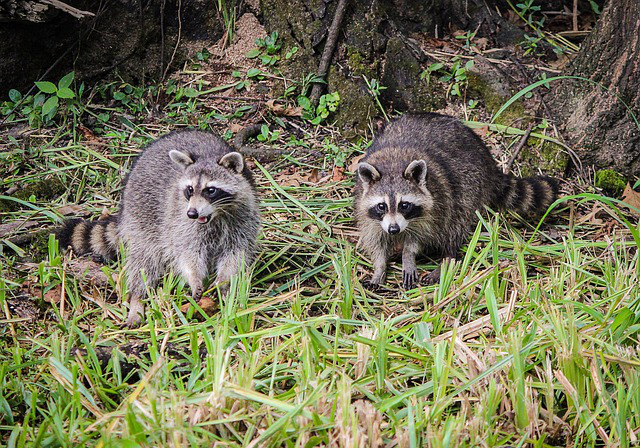

In [31]:
image

In [32]:
image_tensor = transforms.functional.to_tensor(image).to(device)

In [33]:
model.eval()
with tc.no_grad():
  predict = model([image_tensor])

In [34]:
boxes = predict[0]['boxes'].cpu()
labels = predict[0]['labels'].cpu()
scores = predict[0]['scores'].cpu()

In [35]:
boxes

tensor([[342.0447,  99.6848, 565.0101, 299.6718],
        [106.7911, 119.0994, 264.2086, 328.3335],
        [ 92.0657,  97.3727, 480.2816, 340.0109]])

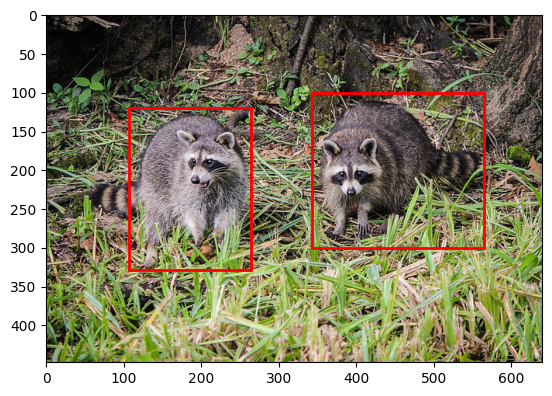

In [36]:
np_arr = image_tensor.permute(1, 2, 0).cpu()
plt.imshow(np_arr)

ax = plt.gca()
for box, label, score in zip(boxes, labels, scores):
  if score>0.7:
    rect = Rectangle((box[0], box[1]),
                     (box[2] - box[0]),
                     (box[3] - box[1]),
                     fill = False,
                     edgecolor = (1, 0, 0),
                     linewidth = 2)
    ax.add_patch(rect)

plt.show()

change backbone

In [ ]:
backbone              = models.mobilenet_v2(True).features
backbone.out_channels = 1280
model0                = models.detection.FasterRCNN(backbone, 2)
model0

In [49]:
model0 = model0.to(device)

change backbone and rpn

In [61]:
backbone              = models.mobilenet_v2(True).features
backbone.out_channels = 1280
anchor_generator      = models.detection.rpn.AnchorGenerator(sizes = ((64, 128, 256, 512), ), aspect_ratios = ((0.5, 1., 1.5, 2.), ))
model0                = models.detection.FasterRCNN(backbone, 2, rpn_anchor_generator = anchor_generator)
model0.rpn

RegionProposalNetwork(
  (anchor_generator): AnchorGenerator()
  (head): RPNHead(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(1280, 1280, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (cls_logits): Conv2d(1280, 16, kernel_size=(1, 1), stride=(1, 1))
    (bbox_pred): Conv2d(1280, 64, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [62]:
model0 = model0.to(device)

In [63]:
optimizer = optim.SGD(model0.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 1e-4)
shedular  = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 1000, eta_min = 1e-6)

In [64]:
start, end = 0, 20
for i in range(start, end):

  model0, train_loss = train_one_epoch(model0, train_loader, None,  optimizer, shedular, i)
  map = validation(model0, test_loader, None, device)

Epoch=0: 100%|██████████| 87/87 [00:28<00:00,  3.04batch/s, loss=0.723]


|| mAP               = 0.0096      ||    mAP|50     = 0.017    ||   mAP|75    =0.0093  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.0    ||   mAP|large = 0.018 ||
|| mAR|1             = 0.12      ||    mAR|10     = 0.36    ||   mAR|100   = 0.36 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.0    ||   mAR|large = 0.41 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=1: 100%|██████████| 87/87 [00:25<00:00,  3.35batch/s, loss=0.603]


|| mAP               = 0.015      ||    mAP|50     = 0.03    ||   mAP|75    =0.014  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.0    ||   mAP|large = 0.017 ||
|| mAR|1             = 0.19      ||    mAR|10     = 0.32    ||   mAR|100   = 0.32 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.0    ||   mAR|large = 0.37 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=2: 100%|██████████| 87/87 [00:27<00:00,  3.16batch/s, loss=0.495]


|| mAP               = 0.016      ||    mAP|50     = 0.07    ||   mAP|75    =0.0  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.0    ||   mAP|large = 0.019 ||
|| mAR|1             = 0.12      ||    mAR|10     = 0.24    ||   mAR|100   = 0.24 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.0    ||   mAR|large = 0.27 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=3: 100%|██████████| 87/87 [00:29<00:00,  2.99batch/s, loss=0.37]


|| mAP               = 0.05      ||    mAP|50     = 0.098    ||   mAP|75    =0.03  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.0091    ||   mAP|large = 0.056 ||
|| mAR|1             = 0.28      ||    mAR|10     = 0.44    ||   mAR|100   = 0.44 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.1    ||   mAR|large = 0.49 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=4: 100%|██████████| 87/87 [00:29<00:00,  2.94batch/s, loss=0.333]


|| mAP               = 0.071      ||    mAP|50     = 0.14    ||   mAP|75    =0.038  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.0    ||   mAP|large = 0.081 ||
|| mAR|1             = 0.28      ||    mAR|10     = 0.41    ||   mAR|100   = 0.41 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.0    ||   mAR|large = 0.47 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=5: 100%|██████████| 87/87 [00:29<00:00,  2.91batch/s, loss=0.32]


|| mAP               = 0.087      ||    mAP|50     = 0.15    ||   mAP|75    =0.12  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.0    ||   mAP|large = 0.099 ||
|| mAR|1             = 0.45      ||    mAR|10     = 0.45    ||   mAR|100   = 0.45 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.0    ||   mAR|large = 0.51 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=6: 100%|██████████| 87/87 [00:29<00:00,  2.97batch/s, loss=0.3]


|| mAP               = 0.049      ||    mAP|50     = 0.098    ||   mAP|75    =0.037  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.0    ||   mAP|large = 0.056 ||
|| mAR|1             = 0.34      ||    mAR|10     = 0.45    ||   mAR|100   = 0.45 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.0    ||   mAR|large = 0.51 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=7: 100%|██████████| 87/87 [00:29<00:00,  2.93batch/s, loss=0.293]


|| mAP               = 0.049      ||    mAP|50     = 0.11    ||   mAP|75    =0.018  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.0    ||   mAP|large = 0.055 ||
|| mAR|1             = 0.31      ||    mAR|10     = 0.39    ||   mAR|100   = 0.39 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.0    ||   mAR|large = 0.44 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=8: 100%|██████████| 87/87 [00:29<00:00,  2.96batch/s, loss=0.292]


|| mAP               = 0.049      ||    mAP|50     = 0.1    ||   mAP|75    =0.031  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.0    ||   mAP|large = 0.056 ||
|| mAR|1             = 0.3      ||    mAR|10     = 0.41    ||   mAR|100   = 0.41 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.0    ||   mAR|large = 0.47 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=9: 100%|██████████| 87/87 [00:28<00:00,  3.00batch/s, loss=0.293]


|| mAP               = 0.054      ||    mAP|50     = 0.12    ||   mAP|75    =0.035  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.0    ||   mAP|large = 0.062 ||
|| mAR|1             = 0.38      ||    mAR|10     = 0.39    ||   mAR|100   = 0.39 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.0    ||   mAR|large = 0.44 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=10: 100%|██████████| 87/87 [00:29<00:00,  2.99batch/s, loss=0.277]


|| mAP               = 0.048      ||    mAP|50     = 0.1    ||   mAP|75    =0.029  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.0    ||   mAP|large = 0.055 ||
|| mAR|1             = 0.32      ||    mAR|10     = 0.35    ||   mAR|100   = 0.35 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.0    ||   mAR|large = 0.4 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=11: 100%|██████████| 87/87 [00:28<00:00,  3.00batch/s, loss=0.287]


|| mAP               = 0.059      ||    mAP|50     = 0.092    ||   mAP|75    =0.058  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.0    ||   mAP|large = 0.068 ||
|| mAR|1             = 0.44      ||    mAR|10     = 0.44    ||   mAR|100   = 0.44 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.0    ||   mAR|large = 0.5 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=12: 100%|██████████| 87/87 [00:28<00:00,  3.02batch/s, loss=0.292]


|| mAP               = 0.062      ||    mAP|50     = 0.14    ||   mAP|75    =0.034  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.0    ||   mAP|large = 0.07 ||
|| mAR|1             = 0.4      ||    mAR|10     = 0.4    ||   mAR|100   = 0.4 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.0    ||   mAR|large = 0.46 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=13: 100%|██████████| 87/87 [00:29<00:00,  2.97batch/s, loss=0.279]


|| mAP               = 0.051      ||    mAP|50     = 0.094    ||   mAP|75    =0.031  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.0    ||   mAP|large = 0.058 ||
|| mAR|1             = 0.38      ||    mAR|10     = 0.38    ||   mAR|100   = 0.38 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.0    ||   mAR|large = 0.43 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=14: 100%|██████████| 87/87 [00:28<00:00,  3.00batch/s, loss=0.295]


|| mAP               = 0.042      ||    mAP|50     = 0.09    ||   mAP|75    =0.026  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.0    ||   mAP|large = 0.048 ||
|| mAR|1             = 0.31      ||    mAR|10     = 0.38    ||   mAR|100   = 0.38 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.0    ||   mAR|large = 0.43 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=15: 100%|██████████| 87/87 [00:29<00:00,  2.94batch/s, loss=0.279]


|| mAP               = 0.056      ||    mAP|50     = 0.13    ||   mAP|75    =0.015  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.0    ||   mAP|large = 0.063 ||
|| mAR|1             = 0.4      ||    mAR|10     = 0.4    ||   mAR|100   = 0.4 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.0    ||   mAR|large = 0.46 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=16: 100%|██████████| 87/87 [00:29<00:00,  2.97batch/s, loss=0.279]


|| mAP               = 0.054      ||    mAP|50     = 0.12    ||   mAP|75    =0.038  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.013    ||   mAP|large = 0.06 ||
|| mAR|1             = 0.32      ||    mAR|10     = 0.4    ||   mAR|100   = 0.4 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.1    ||   mAR|large = 0.44 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=17: 100%|██████████| 87/87 [00:30<00:00,  2.87batch/s, loss=0.26]


|| mAP               = 0.044      ||    mAP|50     = 0.083    ||   mAP|75    =0.025  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.0    ||   mAP|large = 0.051 ||
|| mAR|1             = 0.39      ||    mAR|10     = 0.43    ||   mAR|100   = 0.43 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.0    ||   mAR|large = 0.49 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=18: 100%|██████████| 87/87 [00:30<00:00,  2.82batch/s, loss=0.251]


|| mAP               = 0.05      ||    mAP|50     = 0.092    ||   mAP|75    =0.057  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.0    ||   mAP|large = 0.058 ||
|| mAR|1             = 0.38      ||    mAR|10     = 0.38    ||   mAR|100   = 0.38 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.0    ||   mAR|large = 0.43 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=19: 100%|██████████| 87/87 [00:32<00:00,  2.71batch/s, loss=0.224]


|| mAP               = 0.06      ||    mAP|50     = 0.14    ||   mAP|75    =0.032  ||
|| mAP|small         = -1.0      ||    mAP|medium = 0.0    ||   mAP|large = 0.07 ||
|| mAR|1             = 0.45      ||    mAR|10     = 0.49    ||   mAR|100   = 0.49 ||
|| mAR|small         = -1.0      ||    mAR|medium = 0.0    ||   mAR|large = 0.56 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


In [65]:
image = Image.open('/content/raccoon_dataset/images/raccoon-117.jpg').convert('RGB')

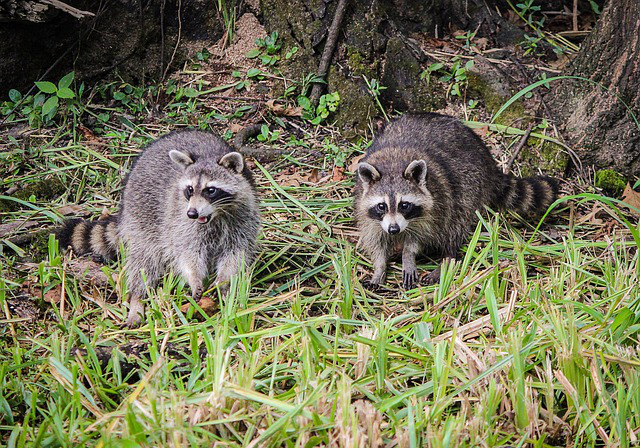

In [66]:
image

In [67]:
image_tensor = transforms.functional.to_tensor(image).to(device)

In [69]:
model0.eval()
with tc.no_grad():
  predict = model0([image_tensor])

In [70]:
boxes = predict[0]['boxes'].cpu()
labels = predict[0]['labels'].cpu()
scores = predict[0]['scores'].cpu()

In [71]:
boxes

tensor([[ 42.8621,  56.7993, 307.5759, 374.5607],
        [243.2569,  38.2988, 614.1148, 358.1151],
        [348.4556,  79.1855, 552.6644, 303.5748],
        [ 24.3502, 132.3753, 225.3706, 367.8953]])

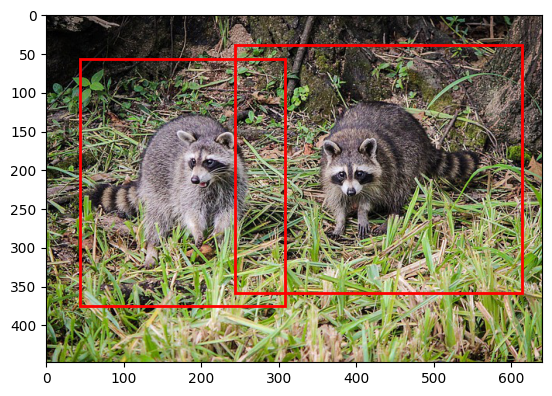

In [73]:
np_arr = image_tensor.permute(1, 2, 0).cpu()
plt.imshow(np_arr)

ax = plt.gca()
for box, label, score in zip(boxes, labels, scores):
  if score>0.5:
    rect = Rectangle((box[0], box[1]),
                     (box[2] - box[0]),
                     (box[3] - box[1]),
                     fill = False,
                     edgecolor = (1, 0, 0),
                     linewidth = 2)
    ax.add_patch(rect)

plt.show()